In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

/home/kai/pythonVirtualEnv/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import sys
print(sys.modules['keras_retinanet'].__file__)
print(sys.modules['keras_resnet'].__file__)
print(sys.modules['keras'].__file__)

/home/kai/.local/lib/python3.5/site-packages/keras_retinanet-0.0.1-py3.5.egg/keras_retinanet/__init__.py
/home/kai/.local/lib/python3.5/site-packages/keras_resnet/__init__.py
/usr/local/lib/python3.5/dist-packages/Keras-2.1.2-py3.5.egg/keras/__init__.py


In [3]:
# model = keras.models.load_model('../snapshots/resnet50_csv_06-10kbatch.h5', custom_objects=custom_objects)
# model = keras.models.load_model('../snapshots/circuit_resnet50_csv_49.h5', custom_objects=custom_objects)
model = keras.models.load_model('../snapshots/circuit_resnet50_csv_02.h5', custom_objects=custom_objects)
# model = keras.models.load_model('/media/kai/Data1/robotPrototype/calibration/modelSnapshots/circuit_resnet50_csv_02.h5', custom_objects=custom_objects)
# print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/usr/local/lib/python3.5/dist-packages/Keras-2.1.2-py3.5.egg/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
def add_noise(inData):
    result = np.random.normal(inData, scale=0.5).astype(np.uint8)
    print("adding noise ---- from {}:{} to {}:{}".format(inData.min(), inData.max(), result.min(), result.max()))
    return result

def set_to_zero(inData):
    result = np.zeros(inData.shape).astype(np.uint8)
    print("adding noise ---- from {}:{} to {}:{}".format(inData.min(), inData.max(), result.min(), result.max()))
    return result



In [ ]:
# Note: this is a huge dataset. Not needed if just doing inference from actual run images

# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
validation_generator = CSVGenerator(
                '/media/kai/Data1/robotPrototype/data/MLRotation/annotation6Tiny.txt',
                '/media/kai/Data1/robotPrototype/data/MLRotation/classname6.txt',
                val_image_data_generator,
                batch_size=10
            )

In [ ]:
# load image
index = np.random.randint(0,16800)
image = validation_generator.load_image(index)
print(image.shape)

In [ ]:
# use this block to test against actual image
# image = cv2.imread("testImg/cellBaseRotated3.bmp.png")
#image = cv2.imread("C:\\Users\\Kai\\study\\robot_prototype\\ur3Control\\tmp\\undistorted.png")
#image = cv2.imread("//KAI-LAPTOP/Users/kai/study/robot_prototype/ur3Control/tmp/undistorted.png")
index = 0
image = cv2.imread("/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png")
print(image.shape)

In [ ]:
image = add_noise(image)

In [ ]:

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = validation_generator.preprocess_image(image)
print(image.shape)
image, scale = validation_generator.resize_image(image)
print(image.shape)
annotations = validation_generator.load_annotations(index)

print(index)
print(validation_generator.image_path(index))
print(scale)
print(annotations)


In [ ]:
# process image
start = time.time()
detections = None
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
print(predicted_labels[0:10])
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
print(scores[0:10])
# correct for image scale
detections[0, :, :4] /= scale


## Physical measurement:

- center of left hole to edge clamp of ribbon cable: 9mm
- center of left hole to center of socket: 24.5mm
- center of left hole to center of right circuit feature: 36mm



In [ ]:

# visualize annotations
'''
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(validation_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
'''

centerX = np.zeros(18, dtype=int)
centerY = np.zeros(18, dtype=int)

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(validation_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

    centerX[label] = b[0] + (b[2]-b[0])/2
    centerY[label] = b[1] + (b[3]-b[1])/2
    print(label, centerX[label], centerY[label])
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

print (centerX[14], centerY[14], centerX[15], centerY[15])


# Define function to return 2D pose from image file

## calculate the angle from at least 3 points:
- origin
- left hole
- top hole





In [5]:
# using hole1 as the origin

x0 = 1104
y0 = 477
ORIGIN_LABEL_ID = 3

features = [["rfSocket", 1150-x0, 326-y0, 30],
           ["tab1", 578-x0, 284-y0, 25],
           ["tab2", 1035-x0, 283-y0, 25],
           ["hole1", 1104-x0, 477-y0, 25],
           ["hole2", 387-x0, 729-y0, 50]]

numOrigins = 0
numFeatures = numOrigins + len(features)

print(numFeatures)

5


In [6]:
import numpy as np
import math

initAngle = np.zeros(numFeatures, dtype=float)
index = numOrigins
for feature in features:
    initAngle[index] = math.atan2(feature[2],feature[1]) * 180.0/math.pi
    index = index+1

print(initAngle)

[ -73.05738923 -159.85089519 -109.57895212    0.          160.63523876]


In [7]:

def get2DPose(inFile):
    image = cv2.imread(inFile)
    print(image.shape)
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = validation_generator.preprocess_image(image)
    print(image.shape)
    image, scale = validation_generator.resize_image(image)
    print(image.shape)
    print(scale)
    
    # process image
    start = time.time()
    detections = None
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    # correct for image scale
    detections[0, :, :4] /= scale
    
    b = None
    foundTarget = False
    angle = None
    centerX = np.zeros(numFeatures, dtype=int)
    centerY = np.zeros(numFeatures, dtype=int)

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.5 or centerX[label] != 0:
            continue
            
        b = detections[0, idx, :4].astype(int)
        if label == ORIGIN_LABEL_ID: # using hole1 as the origin
            foundTarget = True
            originX = (b[0]+b[2])/2
            originY = (b[1]+b[3])/2
           
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(validation_generator.label_to_name(label), score)
        cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

        centerX[label] = (b[2]+b[0])/2
        centerY[label] = (b[3]+b[1])/2
        print(label, centerX[label], centerY[label], score)
        
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

    if not foundTarget:
        return -999, -999, -999
    
    
    print("origin and angle", originX, originY, angle)
    
    totalAngle = 0.0
    totalCount = 0
    if not foundTarget:
        angleAvg = angle
    else:
        for labelID in range(0, numFeatures, 1):
            if labelID == ORIGIN_LABEL_ID:
                continue
            if centerX[labelID] != 0 and centerY[labelID] != 0:
                featureAngle = (math.atan2(centerY[labelID] - originY, centerX[labelID] -originX)) * 180.0 / math.pi - initAngle[labelID]
                if featureAngle < -180:
                    featureAngle = featureAngle + 360
                elif featureAngle > 180:
                    featureAngle = 360 - featureAngle
                print("featureAngle:", labelID, centerX[labelID], centerY[labelID], featureAngle)
                totalAngle = totalAngle + featureAngle
                totalCount = totalCount + 1
    
        angleAvg = totalAngle / totalCount
    print("returning", originX, originY, angleAvg)
    return originX, originY, angleAvg

In [ ]:
method = eval('cv2.TM_CCOEFF_NORMED')

In [ ]:
import os
import cv2

def getMatchedOrigin(inFile, angle, xCenter, yCenter):
    origin_length = 25 # length on either side of origin
    
    command = "convert origin.png -distort SRT '{},{},1,{},{},{}' -alpha off tmp_origin_out.png".format(origin_length, origin_length, angle, origin_length, origin_length)
    print(command)
    result = os.system(command)
    print(result)
    cropped_length = 40

    img = cv2.imread(inFile)
    template = cv2.imread('tmp_origin_out.png')

    img = img[yCenter-cropped_length:yCenter+cropped_length, xCenter-cropped_length:xCenter+cropped_length]
    # plt.imsave("tmp_cropped.png", img)

    res = cv2.matchTemplate(img, template, method)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    print("max_val: ", max_val)
    print("max_loc: ", max_loc)
    print("max_center: ", max_loc[0]+origin_length, max_loc[1]+origin_length)

    xResult = xCenter-cropped_length+max_loc[0]+origin_length
    yResult = yCenter-cropped_length+max_loc[1]+origin_length
    print(xResult, yResult)
    return xResult, yResult



# Create Server to respond to identification request

In [ ]:
import socket
import time

HOST = "192.168.1.116" #The remote host
PORT = 3001 # The same port as used by the server
print("Starting 2d id program")

In [ ]:
returnVal = None

In [ ]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

validation_generator = CSVGenerator(
                '/media/kai/Data1/robotPrototype/calibration/MLRotation/annotation6Tiny.txt',
                '/media/kai/Data1/robotPrototype/calibration/MLRotation/classname6.txt',
                val_image_data_generator,
                batch_size=10
            )

In [ ]:
finishedLoop = False
while finishedLoop == False:
    print("Waiting for connections...")
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.bind((HOST, PORT)) # Bind to the port 
    s.listen(5) # Now wait for client connection.
    c, addr = s.accept() # Establish connection with client.
    print("Connected")
    foundError = False
    finishedInner = False
    while foundError == False and finishedInner == False:
        try:
            msg = c.recv(40).decode("utf-8").strip()
            if msg != "":
                print("received: " + msg)
            time.sleep(1)
            if msg == "acquireCircuitOrigin":
                print("acquiring...")
                inFileName = "/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png"
                x,y,a = get2DPose(inFileName)
                if x == -999:
                    returnVal = "None Found"
                else:    
                    print("initialPos:     ", x, y, a)
                    x, y = getMatchedOrigin(inFileName, int(round(a)), int(round(x)), int(round(y)))
                    print("fine tuned Pos: ", x, y, a)
                    x = (-0.1618 * x + 89.08)/1000.0
                    y = (-0.1627 * y + 178.933)/1000.0
                    z = -24.0/1000.0
                    rx = 0.0
                    ry = 0.0
                    rz = a / 180.0 * math.pi
                    returnVal = "{0:8.4f}, {1:8.4f}, {2:8.4f}, {3:6.3f}, {4:6.3f}, {5:6.3f}".format(x, y, z, rx, ry, rz)
                print("sending: ", returnVal)
                c.send(returnVal.encode())
                finishedInner = True
            elif msg == "getCircuitOrigin":
                returnString = "({})\n".format(returnVal)
                c.send(returnString.encode())
                print(returnString)
                finishedInner = True
            elif msg == "end":
                finishedLoop = True
                finishedInner = True
        except socket.error as socketError:
            print(socketError)
            foundError = True
    c.close()
    s.close()

In [ ]:
c.close()
s.close()

# Tests

In [9]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

validation_generator = CSVGenerator(
                '/media/kai/Data1/robotPrototype/data/MLRotation/annotation180319.txt',
                '/media/kai/Data1/robotPrototype/data/MLRotation/classname180319.txt',
                val_image_data_generator,
                batch_size=10
            )

In [ ]:
#testFile = "/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png"
#testFile = "/media/kai/Data1/robotPrototype/data/MLRotation/resultImg6/out_330_460_-10.png"
testFile = "/media/kai/Data1/robotPrototype/data/MLRotation/circuitBoard180319.png"
#testFile = "/media/kai/Data1/robotPrototype/data/180115WideAngleCalibration/wideAngleImage1.undistorted.png"

result = get2DPose(testFile)
# result = get2DPose("\\\\KAI-LAPTOP\\Users\\kai\\study\\robot_prototype\\ur3Control\\tmp\\undistorted.png")
# result = get2DPose("C:\\Users\\Kai\\study\\robot_prototype\\pyCameraCalibration\\result\\raw\\img65.jpg.png")
print(testFile, int(round(result[2])), int(round(result[0])), int(round(result[1])))

xResult, yResult = getMatchedOrigin(testFile, int(round(result[2])), int(round(result[0])), int(round(result[1])))
print (xResult, yResult)

(957, 1276, 3)
(957, 1276, 3)
(600, 800, 3)
0.6269592476489029
processing time:  1.1159653663635254
0 999 180 0.999987
4 198 500 0.9999862
2 889 124 0.9998534
3 937 324 0.9996996
1 435 78 0.9991425


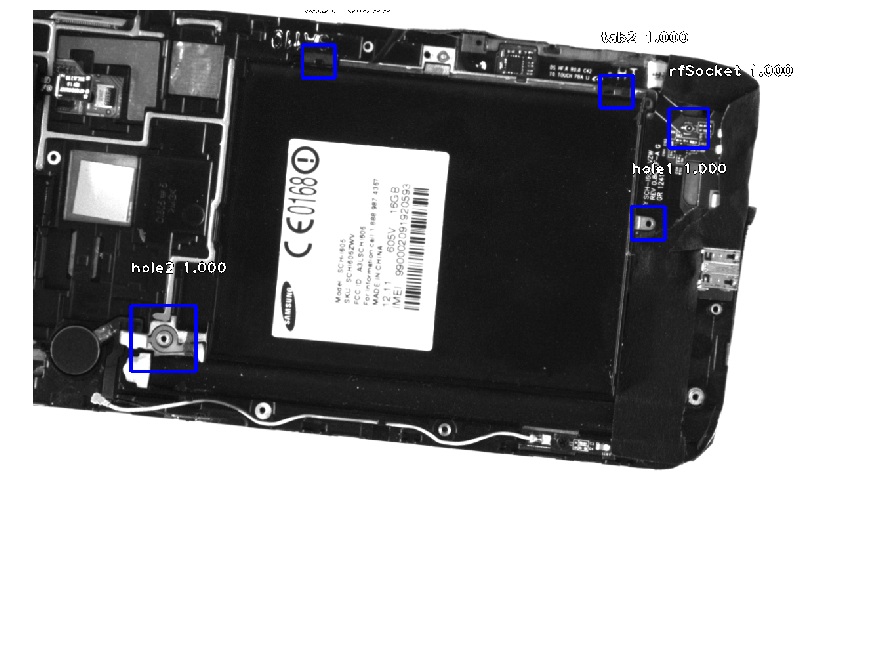

origin and angle 937.5 324.5 None
featureAngle: 0 999 180 6.112261538673309
featureAngle: 1 435 78 5.981028708719521
featureAngle: 2 889 124 5.980586747642391
featureAngle: 4 198 500 6.01416933278017
returning 937.5 324.5 6.022011581953848


In [10]:
# testFile = "/media/kai/Data1/robotPrototype/data/MLRotation/resultImg4/out_400_200_25.png"
#testFile = "/media/kai/Data1/robotPrototype/data/180109OriginInferenceIssue/undistorted.png"
#testFile = "/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png"
#testFile = "/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png"
#testFile = "/media/kai/Data1/robotPrototype/data/MLRotation/circuitBoard180319.png"
testFile = "/media/kai/Data1/robotPrototype/data/MLRotation/180319/out_1000_180_6.png"

result = get2DPose(testFile)

In [ ]:

xResult, yResult = getMatchedOrigin(testFile, -5, 500, 385)